Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from zipfile import ZipFile
import zipfile
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
#tf.__version__
import gc
gc.collect()
tf.keras.backend.clear_session()

In [3]:
print(tf.config.list_physical_devices('CPU'))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
#!pip install --upgrade tensorflow

In [5]:

#import tensorflow as tf
#tpu = resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='TPU')
#tf.config.experimental_connect_to_cluster(resolver)
#tf.tpu.experimental.initialize_tpu_system(resolver)
#strategy = tf.distribute.TPUStrategy(tpu)
#tf.__version__, strategy

In [6]:
### If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [7]:
def get_all_file_paths(directory):

    # initializing empty file paths list
    file_paths = []

    # crawling through directory and subdirectories
    for root,subdir,filename in os.walk(directory):
      for name in subdir:
        #print(name)
        if(name=='Train' or name=='Test'):
        #join the two strings in order to form the full filepath.
            filepath = os.path.join(root, name).replace("\\","/")
            file_paths.append(filepath)


    # returning all file paths
    return file_paths

In [8]:
zip_loc="CNN_assignment.zip"
#"/content/gdrive/MyDrive/CNN/CNN_assignment.zip"
ext_loc="/dataset"
with ZipFile(zip_loc,'r') as zip_ref:
  zip_ref.extractall(ext_loc)


In [9]:
paths=get_all_file_paths(ext_loc)
paths

['/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train']

In [10]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(paths[1])
data_dir_test = pathlib.Path(paths[0])
print(f"Training set --> {data_dir_train}")
print(f"Test set --> {data_dir_test}")

Training set --> \dataset\Skin cancer ISIC The International Skin Imaging Collaboration\Train
Test set --> \dataset\Skin cancer ISIC The International Skin Imaging Collaboration\Test


In [11]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [13]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [14]:
#Check id labels are already hot encoded
%pwd

'D:\\DLNN\\Assignment'

In [15]:
for img,lbl in train_ds.take(1):
  print("Image shape :",img.shape)
  print("Label shape :",lbl.shape)

Image shape : (32, 180, 180, 3)
Label shape : (32,)


In [16]:
#define one hot encoding function

In [17]:
def one_hot_encode(image,label):
  label=tf.one_hot(label,depth=9)
  return image,label

In [18]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [19]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [20]:
def plot_imgs(flag):
    plt.figure(figsize=(10,10))
    for img,lbl in train_ds.take(1):
        for i in range(9):
            #print(lbl[i])
            plt.subplot(3,3,i+1)
            plt.imshow(img[i].numpy().astype('uint8'))
            if(flag==True):            
                class_idx=np.argmax(lbl[i].numpy())
            else:
                class_idx=lbl[i]
            plt.title(class_names[class_idx])
            plt.axis("off")
        #plt.suptitle("Image Details",fontsize=12)
    plt.show()

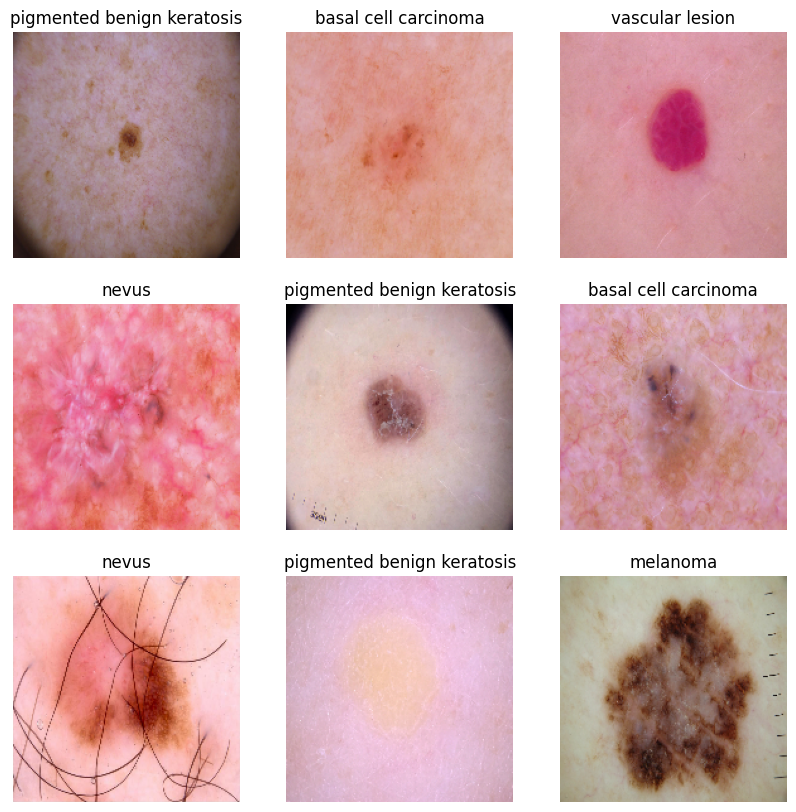

In [21]:
#import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
            
plot_imgs(False)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [23]:
target_labels=9
model=Sequential([
    layers.Input(shape=(img_height,img_width,3)),
    layers.Rescaling(1./255),
    layers.Conv2D(16,(3,3),activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,(3,3),activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dense(target_labels,activation="softmax")
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [24]:
#one hot encoding the data set labels

In [25]:
train_ds=train_ds.map(one_hot_encode)
val_ds=val_ds.map(one_hot_encode)

In [26]:
for img,lbl in train_ds.take(1):
  print("Image shape :",img.shape)
  print("Label shape :",lbl.shape)

Image shape : (32, 180, 180, 3)
Label shape : (32, 9)


In [27]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [28]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,276,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,301,673 (12.59 MB)

 Trainable params: 3,301,673 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [29]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 288ms/step - accuracy: 0.1795 - loss: 2.2064 - val_accuracy: 0.3221 - val_loss: 1.8519
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.3187 - loss: 1.8091 - val_accuracy: 0.4027 - val_loss: 1.6854
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 228ms/step - accuracy: 0.4108 - loss: 1.6691 - val_accuracy: 0.5101 - val_loss: 1.5088
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 238ms/step - accuracy: 0.4756 - loss: 1.5062 - val_accuracy: 0.5213 - val_loss: 1.4899
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 254ms/step - accuracy: 0.5166 - loss: 1.3660 - val_accuracy: 0.5145 - val_loss: 1.4541
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.5452 - loss: 1.3150 - val_accuracy: 0.5324 - val_loss: 1.3725
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 239ms/step - accuracy: 0.5736 - loss: 1.1795 - val_accuracy: 0.4922 - val_loss: 1.4255
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - accuracy: 0.5475 - loss: 1.2029 - val_accu

### Visualizing training results

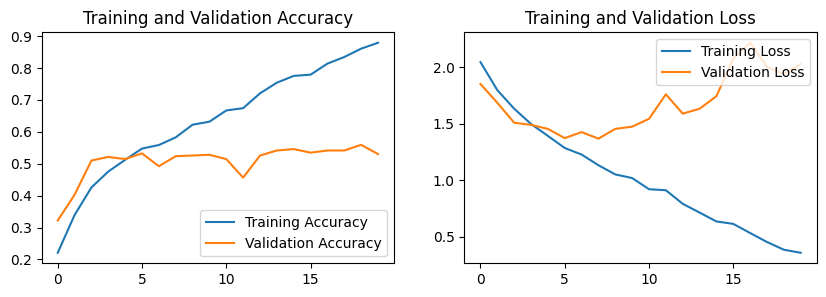

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

1. The model has shown the trainig accuracy to be steadily increase till 88 percent, however the validation accuracy has been compromised and loss has been increasing steadily too.
2. The model has shown high training accuracy but low validation accuracy thereby suggesting that the model has learnt all the patterns as well as the noise in dataset, which implies overfitting which could be due to the low volume dataset, so overcome overfitting we'd try to eploy the image augmentation by means of flip (left/right, up/down), mirror image rotations. 

In [31]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

In [32]:
augmented=Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

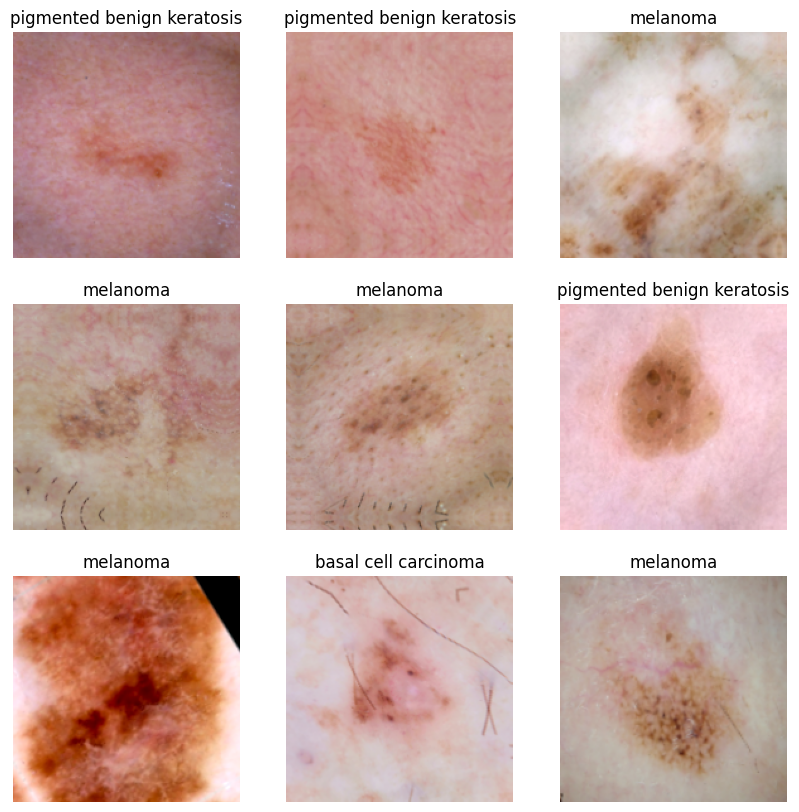

In [33]:
#import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))
for img,lbl in train_ds.take(1):
    for i in range(9):
        #print(lbl[i])
        img_aug=augmented(img)
        plt.subplot(3,3,i+1)
        plt.imshow(img_aug[i].numpy().astype('uint8'))          
        class_idx=np.argmax(lbl[i].numpy())
        plt.title(class_names[class_idx])
        plt.axis("off")
        #plt.suptitle("Image Details",fontsize=12)
plt.show()

### Todo:
### Create the model, compile and train the model


In [34]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
target_labels=9
model=Sequential([
    #layers.Input(shape=),
    augmented,
    layers.Rescaling(1./255),
    layers.Conv2D(16,(3,3),activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,(3,3),activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dense(target_labels,activation="softmax")
])



### Compiling the model

In [35]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 178, 178, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 89, 89, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 87, 87, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 43, 43, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 41, 41, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 20, 20, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 20, 20, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 25600)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 128)                   │       3,276,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 9)                     │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,301,673 (12.59 MB)

 Trainable params: 3,301,673 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [37]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 325ms/step - accuracy: 0.1985 - loss: 2.1873 - val_accuracy: 0.3758 - val_loss: 1.7322
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - accuracy: 0.4262 - loss: 1.6356 - val_accuracy: 0.4385 - val_loss: 1.6075
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 315ms/step - accuracy: 0.4874 - loss: 1.5139 - val_accuracy: 0.4519 - val_loss: 1.6368
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 321ms/step - accuracy: 0.4829 - loss: 1.5410 - val_accuracy: 0.5056 - val_loss: 1.4337
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 316ms/step - accuracy: 0.5062 - loss: 1.4258 - val_accuracy: 0.5011 - val_loss: 1.3998
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 296ms/step - accuracy: 0.5176 - loss: 1.4170 - val_accuracy: 0.5145 - val_loss: 1.3957
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.5188 - loss: 1.3393 - val_accuracy: 0.4474 - val_loss: 1.6319
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 287ms/step - accuracy: 0.4953 - loss: 1.4283 - val_accu

### Visualizing the results

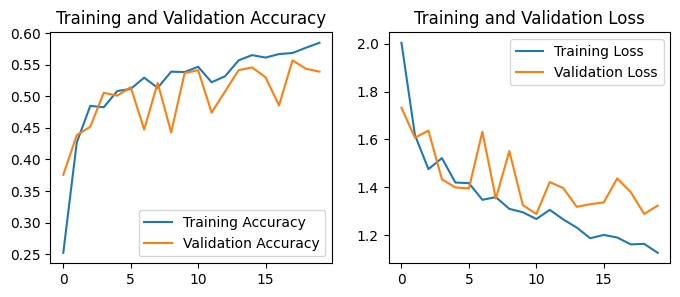

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
1. After incorporating augmentation and dropout we were able to address the issue of the overfitting.
2. As per the output and the graph we can see both the tarining and validation accuracy are steady and exhibit similar trends.
3. But now the model is showing underfittign behaviour as the accuracy stalls at around 57%

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [39]:
## Your code goes here.
class_counts = {}

for class_name in class_names:  # class names from directory
    class_path = os.path.join(data_dir_train, class_name)  #path to the directory class
    class_counts[class_name] = len(os.listdir(class_path))  # images count

df=pd.DataFrame(list(class_counts.items()),columns=["Label","count"])
df["%age"]=round(100*(df["count"]/df["count"].sum()),2)

df.sort_values(by=["count"],ascending=False)

,Label,count,%age
5,pigmented benign keratosis,462,20.63
3,melanoma,438,19.56
1,basal cell carcinoma,376,16.79
4,nevus,357,15.94
7,squamous cell carcinoma,181,8.08
8,vascular lesion,139,6.21
0,actinic keratosis,114,5.09
2,dermatofibroma,95,4.24
6,seborrheic keratosis,77,3.44


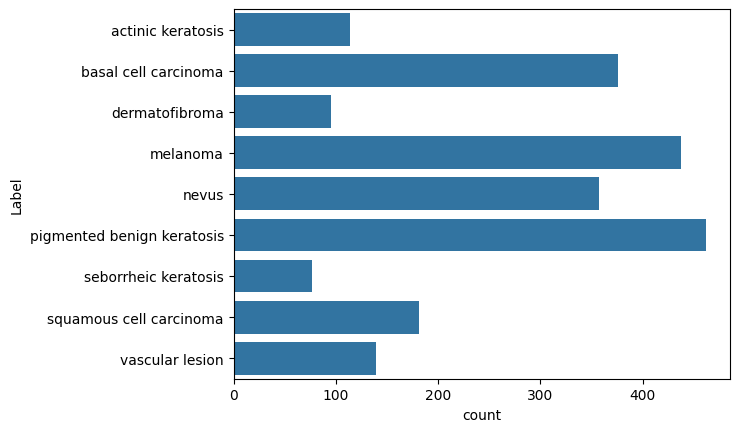

In [40]:
import seaborn as sns
sns.barplot(y="Label",x='count',data=df)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


1. There is clearly a class imbalance, since not all the classes have equal number of images.
2. seborrheic keratosis is the class with least number of images.
3. pigmented benign keratosis and melanoma have the highest number of data images around 21% and 20% aproximately.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [41]:
!pip install Augmentor


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [42]:
path_to_training_dataset=str(data_dir_train)+'/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to \dataset\Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2074DAA9D60>: 100%|█| 500/500 [00:02<00:


Initialised with 376 image(s) found.
Output directory set to \dataset\Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2074DAAA720>: 100%|█| 500/500 [00:02<00:00, 249.50 Samples


Initialised with 95 image(s) found.
Output directory set to \dataset\Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2074FF11790>: 100%|█| 500/500 [00:02<00:00, 245.95 Samples


Initialised with 438 image(s) found.
Output directory set to \dataset\Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2074DA26060>: 100%|█| 500/500 [00:10<00:00, 48.18 Samples


Initialised with 357 image(s) found.
Output directory set to \dataset\Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x2074408ECF0>: 100%|█| 500/500 [00:08<00:00, 55.69 Sample


Initialised with 462 image(s) found.
Output directory set to \dataset\Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2074598E720>: 100%|█| 500/500 [00:02<00:00, 243.01 Samples


Initialised with 77 image(s) found.
Output directory set to \dataset\Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2074FF49970>: 100%|█| 500/500 [00:04<00:00, 110.15 Sample


Initialised with 181 image(s) found.
Output directory set to \dataset\Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2074FEF6810>: 100%|█| 500/500 [00:01<00:00, 252.81 Samples


Initialised with 139 image(s) found.
Output directory set to \dataset\Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2074DA51700>: 100%|█| 500/500 [00:02<00:


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [43]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [45]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['\\dataset\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0be67755-215e-48e2-831f-9fdedb01bb9f.jpg',
 '\\dataset\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_67137909-43c2-46ab-88c7-5ac23f606c12.jpg',
 '\\dataset\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_916dcd0e-8fdf-474b-8267-f25564248615.jpg',
 '\\dataset\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_ae40e938-b945-4f80-968e-101b2997d7c1.jpg',
 '\\dataset\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_af861b35-25a4-45ad-9b76-f1399b96afcf.jpg']

In [46]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new
set(lesion_list_new)

{'actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion'}

In [47]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [48]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df3=df2.groupby(["Label"], as_index=False).count()
df3.rename(columns={'Path':"count"},inplace=True)
new_df=df3
new_df["count"]=new_df["count"]+df["count"]
new_df.sort_values(by="count",ascending=False)

,Label,count
5,pigmented benign keratosis,962
3,melanoma,938
1,basal cell carcinoma,876
4,nevus,857
7,squamous cell carcinoma,681
8,vascular lesion,639
0,actinic keratosis,614
2,dermatofibroma,595
6,seborrheic keratosis,577


In [49]:
new_df

,Label,count
0,actinic keratosis,614
1,basal cell carcinoma,876
2,dermatofibroma,595
3,melanoma,938
4,nevus,857
5,pigmented benign keratosis,962
6,seborrheic keratosis,577
7,squamous cell carcinoma,681
8,vascular lesion,639


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [55]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [56]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [57]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [65]:
## your code goes here
target_labels=9
model=Sequential([
    #layers.Input(shape=(img_height,img_width,3)),
    augmented,
    layers.Rescaling(1./255),
    layers.Conv2D(16,(3,3),activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(32,(3,3),activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dense(target_labels,activation="softmax")
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [66]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 106s 604ms/step - accuracy: 0.3177 - loss: 4.0179 - val_accuracy: 0.1151 - val_loss: 15.7699
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 104s 616ms/step - accuracy: 0.4310 - loss: 1.5845 - val_accuracy: 0.1878 - val_loss: 8.9968
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 104s 615ms/step - accuracy: 0.4595 - loss: 1.4606 - val_accuracy: 0.3742 - val_loss: 2.2074
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 96s 569ms/step - accuracy: 0.4987 - loss: 1.3187 - val_accuracy: 0.5115 - val_loss: 1.2709
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 91s 536ms/step - accuracy: 0.5148 - loss: 1.2739 - val_accuracy: 0.5316 - val_loss: 1.2519
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 100s 593ms/step - accuracy: 0.5230 - loss: 1.2189 - val_accuracy: 0.4989 - val_loss: 1.3816
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 97s 577ms/step - accuracy: 0.5562 - loss: 1.1621 - val_accuracy: 0.4885 - val_loss: 1.4418
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 98s 582ms/step - accuracy: 0.5622 - lo

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

